In [1]:
from gurobipy import Model, quicksum, GRB
import importlib
import src.topo
importlib.reload(src.topo)
from src.topo import ChargingNetwork

import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
flight_time = np.array([[0,2,4,4,4,3],
                        [2,0,2,3,3,4],
                        [4,2,0,3,2,5],
                        [4,3,3,0,2,3],
                        [4,3,2,2,0,1],
                        [3,4,5,3,1,0]])
energy_consumption = flight_time * 2
od_matrix = np.array([[0,1,1,1,1,1],
                      [1,0,0,0,0,0],
                      [1,0,0,0,0,0],
                      [1,0,0,0,0,0],
                      [1,0,0,0,0,0],
                      [1,0,0,0,0,0]])


In [3]:
cn = ChargingNetwork(vertiports=['LAX', 'DTLA', 'LGB', 'WDHL', 'ELSG', 'US'],
                     flight_time=flight_time,
                     energy_consumption=energy_consumption,
                     od_matrix=od_matrix)
nodes, supply, edges, cost, c = cn.populate_network()

58016

In [2]:
schedule = pd.read_csv("../input/schedule_5min_0612.csv")

In [3]:
topo = NetworkTopology(vertiports=['LAX', 'DTLA'], 
                       flight_time=np.array([[0,2],[2,0]]), 
                       energy_consumption=np.array([[0,4],[4,0]]))

In [4]:
nodes, supply, edges, cost, c = topo.populate_network()

In [5]:
K=32
def get_flight_edges(i, model_param):
    v1, v2, t = i
    return quicksum(model_param[(v1, t, k), (v2, t+2, k-4)] for k in range(4,K+1))
 


In [6]:
def get_flight_edges(i, model_param):
    v1, v2, t = i
    return quicksum(model_param[(v1, t, k), (v2, t+2, k-4)] for k in range(4,K))

In [7]:
schedule['schedule'] = schedule['schedule'] // 5
schedule['schedule'] = schedule['schedule'].astype(int)

In [8]:
grouped_schedule = schedule.groupby(['od', 'schedule']).size().reset_index()

In [9]:
flight_demand = {}
od_key = {'LAX': 0, 'DTLA': 1}
for i in range(len(grouped_schedule)):
    od, schedule, demand = grouped_schedule.iloc[i]
    o, d = od.split('_')
    o = od_key[o]
    d = od_key[d]
    flight_demand[(o, d, schedule)] = demand

In [10]:
from time import time
# flight_demand = {(0, 1, 0):2, (1, 0, 0):9, (0, 1, 1):3, (1, 0, 1):4}
lambda_s = {i:0 for i in flight_demand.keys()}

# max_iter = 300
# alpha = 0.92
# epsilon = 0.1
# step_size = 0.1
max_iter = 300
alpha = 0.94
epsilon = 0.1
step_size = 0.12

ofv = []
multipliers_to_plot = np.empty((max_iter, len(flight_demand)))
m = Model("LagrangianRelaxationExample")
m.setParam('OutputFlag', 0)
flow = m.addVars(edges, name="flow", lb=0)
print('Building Flow Balance Constraints')
for n in tqdm(nodes):
    m.addConstr(sum(flow[i, j] for i, j in edges if j == n) -
    sum(flow[i, j] for i, j in edges if i == n) == supply.get(n, 0), f"node_{n}")
start_time = time()
print('Solving the Relaxation Problem')
for iteration in tqdm(range(max_iter)):
    primal_objective = quicksum(c[i,j] * flow[i,j] for i,j in edges)
    lagragian_dual_objective = quicksum(lambda_s[i] * (flight_demand[i] - get_flight_edges(i, flow)) for i in flight_demand.keys())
    m.setObjective(primal_objective + lagragian_dual_objective, GRB.MINIMIZE)
    m.optimize()

    subgradeints = {i: flight_demand[i] - get_flight_edges(i, flow).getValue() for i in flight_demand.keys()}

    solution = m.getAttr('x', flow)
    flow_sum = sum(solution[i, j] for (i, j) in edges if i == 'Source' and j == 'Sink')
    primal_ofv = primal_objective.getValue()
    lr_ofv = lagragian_dual_objective.getValue()
    subgradients = subgradeints

    for i in flight_demand.keys():
        lambda_s[i] = max(0, lambda_s[i] + step_size * subgradients[i])

    step_size *= alpha

    if all(abs(subgradient) < epsilon for subgradient in list(subgradients.values())):
        print("Convergence achieved after", iteration, "iterations")
        break

    print("Iteration:", iteration)
    print("Primal Objective:", primal_ofv)
    print("Lagrangian Dual Objective:", lr_ofv)
    print('Total Cost:', primal_ofv + lr_ofv)
    print('Source-Sink Flow:', flow_sum)
    # print('Lagraingian Multipliers:', np.array(list(lambda_s.values())).round(2), "\n")
    multipliers_to_plot[iteration] = list(lambda_s.values())
    ofv.append(primal_ofv + lr_ofv)
    # if lr_ofv > 0:
    #     print("Lagrangian Dual Objective is positive. Stop the algorithm.")
    #     print(lambda_s)
    #     break
        
print('Elapsed Time:', time() - start_time)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-29
Building Flow Balance Constraints


100%|██████████| 19142/19142 [04:42<00:00, 67.67it/s]


Solving the Relaxation Problem


  0%|          | 1/300 [00:01<07:31,  1.51s/it]

Iteration: 0
Primal Objective: 0.0
Lagrangian Dual Objective: 0.0
Total Cost: 0.0
Source-Sink Flow: 20.0


  1%|          | 2/300 [00:10<28:48,  5.80s/it]

Iteration: 1
Primal Objective: 20.0
Lagrangian Dual Objective: -319.7999999999993
Total Cost: -299.7999999999993
Source-Sink Flow: 0.0


  1%|          | 3/300 [00:31<1:03:52, 12.90s/it]

Iteration: 2
Primal Objective: 20.0
Lagrangian Dual Objective: -599.6928000000012
Total Cost: -579.6928000000012
Source-Sink Flow: 0.0


  1%|▏         | 4/300 [00:43<1:02:25, 12.66s/it]

Iteration: 3
Primal Objective: 20.0
Lagrangian Dual Objective: -706.5307680000006
Total Cost: -686.5307680000006
Source-Sink Flow: 0.0


  2%|▏         | 5/300 [00:56<1:01:54, 12.59s/it]

Iteration: 4
Primal Objective: 20.0
Lagrangian Dual Objective: -760.2554035199997
Total Cost: -740.2554035199997
Source-Sink Flow: 0.0


  2%|▏         | 6/300 [01:05<56:32, 11.54s/it]  

Iteration: 5
Primal Objective: 20.0
Lagrangian Dual Objective: -822.5889158207989
Total Cost: -802.5889158207989
Source-Sink Flow: 0.0


  2%|▏         | 7/300 [01:13<50:32, 10.35s/it]

Iteration: 6
Primal Objective: 20.0
Lagrangian Dual Objective: -849.410060665728
Total Cost: -829.410060665728
Source-Sink Flow: 0.0


  3%|▎         | 8/300 [01:20<45:22,  9.32s/it]

Iteration: 7
Primal Objective: 20.0
Lagrangian Dual Objective: -888.9477442760209
Total Cost: -868.9477442760209
Source-Sink Flow: 0.0


  3%|▎         | 9/300 [01:28<43:09,  8.90s/it]

Iteration: 8
Primal Objective: 20.0
Lagrangian Dual Objective: -855.9907746901038
Total Cost: -835.9907746901038
Source-Sink Flow: 0.0


  3%|▎         | 10/300 [01:37<42:46,  8.85s/it]

Iteration: 9
Primal Objective: 20.0
Lagrangian Dual Objective: -813.5717665949043
Total Cost: -793.5717665949043
Source-Sink Flow: 0.0


  4%|▎         | 11/300 [01:44<40:15,  8.36s/it]

Iteration: 10
Primal Objective: 20.0
Lagrangian Dual Objective: -688.6219060664507
Total Cost: -668.6219060664507
Source-Sink Flow: 0.0


  4%|▍         | 12/300 [01:51<37:18,  7.77s/it]

Iteration: 11
Primal Objective: 20.0
Lagrangian Dual Objective: -662.4546498174387
Total Cost: -642.4546498174387
Source-Sink Flow: 0.0


  4%|▍         | 13/300 [01:59<37:21,  7.81s/it]

Iteration: 12
Primal Objective: 20.0
Lagrangian Dual Objective: -643.3118660990528
Total Cost: -623.3118660990528
Source-Sink Flow: 0.0


  5%|▍         | 14/300 [02:07<38:27,  8.07s/it]

Iteration: 13
Primal Objective: 20.0
Lagrangian Dual Objective: -577.176531451585
Total Cost: -557.176531451585
Source-Sink Flow: 0.0


  5%|▌         | 15/300 [02:15<38:19,  8.07s/it]

Iteration: 14
Primal Objective: 20.0
Lagrangian Dual Objective: -564.5701965626984
Total Cost: -544.5701965626984
Source-Sink Flow: 0.0


  5%|▌         | 16/300 [02:25<39:37,  8.37s/it]

Iteration: 15
Primal Objective: 20.0
Lagrangian Dual Objective: -525.5876733149248
Total Cost: -505.5876733149248
Source-Sink Flow: 0.0


  6%|▌         | 17/300 [02:33<40:11,  8.52s/it]

Iteration: 16
Primal Objective: 20.0
Lagrangian Dual Objective: -492.96360979949907
Total Cost: -472.96360979949907
Source-Sink Flow: 0.0


  6%|▌         | 18/300 [02:41<38:51,  8.27s/it]

Iteration: 17
Primal Objective: 20.0
Lagrangian Dual Objective: -481.9786751896637
Total Cost: -461.9786751896637
Source-Sink Flow: 0.0


  6%|▋         | 19/300 [02:49<37:36,  8.03s/it]

Iteration: 18
Primal Objective: 20.0
Lagrangian Dual Objective: -448.4286563403963
Total Cost: -428.4286563403963
Source-Sink Flow: 0.0


  7%|▋         | 20/300 [02:58<39:03,  8.37s/it]

Iteration: 19
Primal Objective: 20.0
Lagrangian Dual Objective: -423.5163404457415
Total Cost: -403.5163404457415
Source-Sink Flow: 0.0


  7%|▋         | 21/300 [03:05<37:44,  8.12s/it]

Iteration: 20
Primal Objective: 20.0
Lagrangian Dual Objective: -395.86106431961406
Total Cost: -375.86106431961406
Source-Sink Flow: 0.0


  7%|▋         | 22/300 [03:13<36:58,  7.98s/it]

Iteration: 21
Primal Objective: 20.0
Lagrangian Dual Objective: -361.2830749391273
Total Cost: -341.2830749391273
Source-Sink Flow: 0.0


  8%|▊         | 23/300 [03:21<36:18,  7.87s/it]

Iteration: 22
Primal Objective: 20.0
Lagrangian Dual Objective: -335.1788484853588
Total Cost: -315.1788484853588
Source-Sink Flow: 0.0


  8%|▊         | 24/300 [03:28<36:03,  7.84s/it]

Iteration: 23
Primal Objective: 20.0
Lagrangian Dual Objective: -308.2845553005802
Total Cost: -288.2845553005802
Source-Sink Flow: 0.0


  8%|▊         | 25/300 [03:36<35:48,  7.81s/it]

Iteration: 24
Primal Objective: 20.0
Lagrangian Dual Objective: -307.2486415760895
Total Cost: -287.2486415760895
Source-Sink Flow: 0.0


  9%|▊         | 26/300 [03:43<35:02,  7.67s/it]

Iteration: 25
Primal Objective: 20.0
Lagrangian Dual Objective: -288.8356526464019
Total Cost: -268.8356526464019
Source-Sink Flow: 0.0


  9%|▉         | 27/300 [03:52<35:49,  7.87s/it]

Iteration: 26
Primal Objective: 20.0
Lagrangian Dual Objective: -266.9737887599797
Total Cost: -246.9737887599797
Source-Sink Flow: 0.0


  9%|▉         | 28/300 [03:59<34:52,  7.69s/it]

Iteration: 27
Primal Objective: 20.0
Lagrangian Dual Objective: -263.75225491236273
Total Cost: -243.75225491236273
Source-Sink Flow: 0.0


 10%|▉         | 29/300 [04:07<35:04,  7.77s/it]

Iteration: 28
Primal Objective: 20.0
Lagrangian Dual Objective: -243.36875956381056
Total Cost: -223.36875956381056
Source-Sink Flow: 0.0


 10%|█         | 30/300 [04:16<36:52,  8.19s/it]

Iteration: 29
Primal Objective: 20.0
Lagrangian Dual Objective: -222.1920745235498
Total Cost: -202.1920745235498
Source-Sink Flow: 0.0


 10%|█         | 31/300 [04:24<36:31,  8.15s/it]

Iteration: 30
Primal Objective: 20.0
Lagrangian Dual Objective: -205.45484473034915
Total Cost: -185.45484473034915
Source-Sink Flow: 0.0


 11%|█         | 32/300 [04:31<34:30,  7.72s/it]

Iteration: 31
Primal Objective: 20.0
Lagrangian Dual Objective: -195.6795526411187
Total Cost: -175.6795526411187
Source-Sink Flow: 0.0


 11%|█         | 33/300 [04:39<35:14,  7.92s/it]

Iteration: 32
Primal Objective: 20.0
Lagrangian Dual Objective: -183.4762328884734
Total Cost: -163.4762328884734
Source-Sink Flow: 0.0


 11%|█▏        | 34/300 [04:48<36:06,  8.15s/it]

Iteration: 33
Primal Objective: 20.0
Lagrangian Dual Objective: -171.38057345294746
Total Cost: -151.38057345294746
Source-Sink Flow: 0.0


 12%|█▏        | 35/300 [04:56<36:19,  8.22s/it]

Iteration: 34
Primal Objective: 20.0
Lagrangian Dual Objective: -163.94961020976663
Total Cost: -143.94961020976663
Source-Sink Flow: 0.0


 12%|█▏        | 36/300 [05:04<35:49,  8.14s/it]

Iteration: 35
Primal Objective: 20.0
Lagrangian Dual Objective: -152.07160696780102
Total Cost: -132.07160696780102
Source-Sink Flow: 0.0


 12%|█▏        | 37/300 [05:13<36:58,  8.43s/it]

Iteration: 36
Primal Objective: 20.0
Lagrangian Dual Objective: -148.35901023366296
Total Cost: -128.35901023366296
Source-Sink Flow: 0.0


 13%|█▎        | 38/300 [05:21<36:21,  8.33s/it]

Iteration: 37
Primal Objective: 20.0
Lagrangian Dual Objective: -136.67525431239739
Total Cost: -116.67525431239739
Source-Sink Flow: 0.0


 13%|█▎        | 39/300 [05:31<37:59,  8.73s/it]

Iteration: 38
Primal Objective: 20.0
Lagrangian Dual Objective: -127.750629526788
Total Cost: -107.750629526788
Source-Sink Flow: 0.0


 13%|█▎        | 40/300 [05:41<39:50,  9.19s/it]

Iteration: 39
Primal Objective: 20.0
Lagrangian Dual Objective: -125.46249765040369
Total Cost: -105.46249765040369
Source-Sink Flow: 0.0


 14%|█▎        | 41/300 [05:51<39:50,  9.23s/it]

Iteration: 40
Primal Objective: 20.0
Lagrangian Dual Objective: -109.81810665770388
Total Cost: -89.81810665770388
Source-Sink Flow: 0.0


 14%|█▍        | 42/300 [05:58<37:42,  8.77s/it]

Iteration: 41
Primal Objective: 20.0
Lagrangian Dual Objective: -107.90402329797325
Total Cost: -87.90402329797325
Source-Sink Flow: 0.0


 14%|█▍        | 43/300 [06:07<37:20,  8.72s/it]

Iteration: 42
Primal Objective: 20.0
Lagrangian Dual Objective: -103.39373333272727
Total Cost: -83.39373333272727
Source-Sink Flow: 0.0


 15%|█▍        | 44/300 [06:17<38:36,  9.05s/it]

Iteration: 43
Primal Objective: 20.0
Lagrangian Dual Objective: -88.71374774689401
Total Cost: -68.71374774689401
Source-Sink Flow: 0.0


 15%|█▌        | 45/300 [06:25<37:31,  8.83s/it]

Iteration: 44
Primal Objective: 20.0
Lagrangian Dual Objective: -86.276477321277
Total Cost: -66.276477321277
Source-Sink Flow: 0.0


 15%|█▌        | 46/300 [06:34<36:53,  8.72s/it]

Iteration: 45
Primal Objective: 20.0
Lagrangian Dual Objective: -83.64780872356393
Total Cost: -63.64780872356393
Source-Sink Flow: 0.0


 16%|█▌        | 47/300 [06:41<35:06,  8.33s/it]

Iteration: 46
Primal Objective: 20.0
Lagrangian Dual Objective: -79.13974603537558
Total Cost: -59.13974603537558
Source-Sink Flow: 0.0


 16%|█▌        | 48/300 [06:49<33:54,  8.08s/it]

Iteration: 47
Primal Objective: 20.0
Lagrangian Dual Objective: -75.56971403631896
Total Cost: -55.569714036318956
Source-Sink Flow: 0.0


 16%|█▋        | 49/300 [06:56<33:02,  7.90s/it]

Iteration: 48
Primal Objective: 20.0
Lagrangian Dual Objective: -68.45087403235644
Total Cost: -48.45087403235644
Source-Sink Flow: 0.0


 17%|█▋        | 50/300 [07:04<33:10,  7.96s/it]

Iteration: 49
Primal Objective: 20.0
Lagrangian Dual Objective: -62.55458193590168
Total Cost: -42.55458193590168
Source-Sink Flow: 0.0


 17%|█▋        | 51/300 [07:11<32:01,  7.71s/it]

Iteration: 50
Primal Objective: 20.0
Lagrangian Dual Objective: -59.462299487719484
Total Cost: -39.462299487719484
Source-Sink Flow: 0.0


 17%|█▋        | 52/300 [07:20<33:06,  8.01s/it]

Iteration: 51
Primal Objective: 20.0
Lagrangian Dual Objective: -58.52721995027401
Total Cost: -38.52721995027401
Source-Sink Flow: 0.0


 18%|█▊        | 53/300 [07:28<32:34,  7.91s/it]

Iteration: 52
Primal Objective: 20.0
Lagrangian Dual Objective: -56.24861084763807
Total Cost: -36.24861084763807
Source-Sink Flow: 0.0


 18%|█▊        | 54/300 [07:37<34:09,  8.33s/it]

Iteration: 53
Primal Objective: 20.0
Lagrangian Dual Objective: -51.27522679136131
Total Cost: -31.275226791361312
Source-Sink Flow: 0.0


 18%|█▊        | 55/300 [07:44<32:54,  8.06s/it]

Iteration: 54
Primal Objective: 20.0
Lagrangian Dual Objective: -45.24453548881028
Total Cost: -25.24453548881028
Source-Sink Flow: 0.0


 19%|█▊        | 56/300 [07:52<31:39,  7.78s/it]

Iteration: 55
Primal Objective: 20.0
Lagrangian Dual Objective: -43.294697018908856
Total Cost: -23.294697018908856
Source-Sink Flow: 0.0


 19%|█▉        | 57/300 [08:00<32:48,  8.10s/it]

Iteration: 56
Primal Objective: 20.0
Lagrangian Dual Objective: -42.98165122136795
Total Cost: -22.981651221367947
Source-Sink Flow: 0.0


 19%|█▉        | 58/300 [08:07<31:12,  7.74s/it]

Iteration: 57
Primal Objective: 20.0
Lagrangian Dual Objective: -39.33377278457408
Total Cost: -19.33377278457408
Source-Sink Flow: 0.0


 20%|█▉        | 59/300 [08:15<31:11,  7.77s/it]

Iteration: 58
Primal Objective: 20.0
Lagrangian Dual Objective: -38.368171890334374
Total Cost: -18.368171890334374
Source-Sink Flow: 0.0


 20%|██        | 60/300 [08:23<31:24,  7.85s/it]

Iteration: 59
Primal Objective: 20.0
Lagrangian Dual Objective: -36.38406996106577
Total Cost: -16.38406996106577
Source-Sink Flow: 0.0


 20%|██        | 61/300 [08:32<32:24,  8.14s/it]

Iteration: 60
Primal Objective: 20.0
Lagrangian Dual Objective: -32.00835843569915
Total Cost: -12.00835843569915
Source-Sink Flow: 0.0


 21%|██        | 62/300 [08:39<30:55,  7.80s/it]

Iteration: 61
Primal Objective: 20.0
Lagrangian Dual Objective: -31.21624184130441
Total Cost: -11.21624184130441
Source-Sink Flow: 0.0


 21%|██        | 63/300 [08:47<30:58,  7.84s/it]

Iteration: 62
Primal Objective: 20.0
Lagrangian Dual Objective: -28.525355306932813
Total Cost: -8.525355306932813
Source-Sink Flow: 0.0


 21%|██▏       | 64/300 [08:54<30:06,  7.65s/it]

Iteration: 63
Primal Objective: 20.0
Lagrangian Dual Objective: -27.869821406251514
Total Cost: -7.869821406251514
Source-Sink Flow: 0.0


 22%|██▏       | 65/300 [09:03<31:16,  7.99s/it]

Iteration: 64
Primal Objective: 20.0
Lagrangian Dual Objective: -25.5434445761091
Total Cost: -5.543444576109099
Source-Sink Flow: 0.0


 22%|██▏       | 66/300 [09:10<29:57,  7.68s/it]

Iteration: 65
Primal Objective: 20.0
Lagrangian Dual Objective: -24.421491440632096
Total Cost: -4.421491440632096
Source-Sink Flow: 0.0


 22%|██▏       | 67/300 [09:18<30:36,  7.88s/it]

Iteration: 66
Primal Objective: 20.0
Lagrangian Dual Objective: -21.642100478180527
Total Cost: -1.6421004781805273
Source-Sink Flow: 0.0


 23%|██▎       | 68/300 [09:26<30:36,  7.92s/it]

Iteration: 67
Primal Objective: 20.0
Lagrangian Dual Objective: -20.32997854656572
Total Cost: -0.32997854656571945
Source-Sink Flow: 0.0


 23%|██▎       | 69/300 [09:34<30:06,  7.82s/it]

Iteration: 68
Primal Objective: 20.0
Lagrangian Dual Objective: -20.39858809053402
Total Cost: -0.39858809053401956
Source-Sink Flow: 0.0


 23%|██▎       | 70/300 [09:41<29:30,  7.70s/it]

Iteration: 69
Primal Objective: 20.0
Lagrangian Dual Objective: -19.833280403808168
Total Cost: 0.1667195961918324
Source-Sink Flow: 0.0


 24%|██▎       | 71/300 [09:50<31:02,  8.13s/it]

Iteration: 70
Primal Objective: 20.0
Lagrangian Dual Objective: -16.810419280361838
Total Cost: 3.189580719638162
Source-Sink Flow: 0.0


 24%|██▍       | 72/300 [09:59<30:58,  8.15s/it]

Iteration: 71
Primal Objective: 20.0
Lagrangian Dual Objective: -17.34472351271861
Total Cost: 2.655276487281391
Source-Sink Flow: 0.0


 24%|██▍       | 73/300 [10:06<30:20,  8.02s/it]

Iteration: 72
Primal Objective: 20.0
Lagrangian Dual Objective: -15.939514030484903
Total Cost: 4.060485969515097
Source-Sink Flow: 0.0


 25%|██▍       | 74/300 [10:15<30:28,  8.09s/it]

Iteration: 73
Primal Objective: 0.0
Lagrangian Dual Objective: 4.814526611209839
Total Cost: 4.814526611209839
Source-Sink Flow: 20.0


 25%|██▌       | 75/300 [10:17<23:27,  6.26s/it]

Iteration: 74
Primal Objective: 20.0
Lagrangian Dual Objective: -17.226248314007012
Total Cost: 2.7737516859929876
Source-Sink Flow: 0.0


 25%|██▌       | 76/300 [10:24<24:16,  6.50s/it]

Iteration: 75
Primal Objective: 20.0
Lagrangian Dual Objective: -15.694281536340299
Total Cost: 4.3057184636597015
Source-Sink Flow: 0.0


 26%|██▌       | 77/300 [10:31<25:33,  6.88s/it]

Iteration: 76
Primal Objective: 20.0
Lagrangian Dual Objective: -14.998607623941382
Total Cost: 5.001392376058618
Source-Sink Flow: 0.0


 26%|██▌       | 78/300 [10:39<26:00,  7.03s/it]

Iteration: 77
Primal Objective: 0.0
Lagrangian Dual Objective: 4.552344247407304
Total Cost: 4.552344247407304
Source-Sink Flow: 20.0


 26%|██▋       | 79/300 [10:41<20:10,  5.48s/it]

Iteration: 78
Primal Objective: 20.0
Lagrangian Dual Objective: -15.732328484846827
Total Cost: 4.2676715151531734
Source-Sink Flow: 0.0


 27%|██▋       | 80/300 [10:47<21:18,  5.81s/it]

Iteration: 79
Primal Objective: 0.0
Lagrangian Dual Objective: 5.222984051102628
Total Cost: 5.222984051102628
Source-Sink Flow: 20.0


 27%|██▋       | 81/300 [10:49<16:21,  4.48s/it]

Iteration: 80
Primal Objective: 20.0
Lagrangian Dual Objective: -15.685929646771253
Total Cost: 4.314070353228747
Source-Sink Flow: 0.0


 27%|██▋       | 82/300 [10:56<19:03,  5.25s/it]

Iteration: 81
Primal Objective: 20.0
Lagrangian Dual Objective: -14.88644406665048
Total Cost: 5.11355593334952
Source-Sink Flow: 0.0


 28%|██▊       | 83/300 [11:02<19:53,  5.50s/it]

Iteration: 82
Primal Objective: 0.0
Lagrangian Dual Objective: 5.039752874750102
Total Cost: 5.039752874750102
Source-Sink Flow: 20.0


 28%|██▊       | 84/300 [11:04<16:04,  4.47s/it]

Iteration: 83
Primal Objective: 20.0
Lagrangian Dual Objective: -15.21642240144237
Total Cost: 4.783577598557629
Source-Sink Flow: 0.0


 28%|██▊       | 85/300 [11:10<17:53,  5.00s/it]

Iteration: 84
Primal Objective: 0.0
Lagrangian Dual Objective: 5.331426288067248
Total Cost: 5.331426288067248
Source-Sink Flow: 20.0


 29%|██▊       | 86/300 [11:12<14:39,  4.11s/it]

Iteration: 85
Primal Objective: 20.0
Lagrangian Dual Objective: -14.262581815770805
Total Cost: 5.737418184229195
Source-Sink Flow: 0.0


 29%|██▉       | 87/300 [11:18<17:00,  4.79s/it]

Iteration: 86
Primal Objective: 0.0
Lagrangian Dual Objective: 5.58045030679093
Total Cost: 5.58045030679093
Source-Sink Flow: 20.0


 29%|██▉       | 88/300 [11:20<13:51,  3.92s/it]

Iteration: 87
Primal Objective: 20.0
Lagrangian Dual Objective: -14.324580561293446
Total Cost: 5.6754194387065535
Source-Sink Flow: 0.0


 30%|██▉       | 89/300 [11:26<16:10,  4.60s/it]

Iteration: 88
Primal Objective: 0.0
Lagrangian Dual Objective: 5.653375098445976
Total Cost: 5.653375098445976
Source-Sink Flow: 20.0


 30%|███       | 90/300 [11:27<12:18,  3.52s/it]

Iteration: 89
Primal Objective: 0.0
Lagrangian Dual Objective: 6.438330524076406
Total Cost: 6.438330524076406
Source-Sink Flow: 20.0


 30%|███       | 91/300 [11:29<10:13,  2.93s/it]

Iteration: 90
Primal Objective: 20.0
Lagrangian Dual Objective: -13.951507929049505
Total Cost: 6.048492070950495
Source-Sink Flow: 0.0


 31%|███       | 92/300 [11:34<11:55,  3.44s/it]

Iteration: 91
Primal Objective: 0.0
Lagrangian Dual Objective: 6.476621311140214
Total Cost: 6.476621311140214
Source-Sink Flow: 20.0


 31%|███       | 93/300 [11:35<09:44,  2.83s/it]

Iteration: 92
Primal Objective: 20.0
Lagrangian Dual Objective: -13.37345967413414
Total Cost: 6.626540325865861
Source-Sink Flow: 0.0


 31%|███▏      | 94/300 [11:40<11:43,  3.42s/it]

Iteration: 93
Primal Objective: 0.0
Lagrangian Dual Objective: 6.3757970586313
Total Cost: 6.3757970586313
Source-Sink Flow: 20.0


 32%|███▏      | 95/300 [11:41<09:41,  2.84s/it]

Iteration: 94
Primal Objective: 0.0
Lagrangian Dual Objective: 6.9518790029061694
Total Cost: 6.9518790029061694
Source-Sink Flow: 20.0


 32%|███▏      | 96/300 [11:43<08:31,  2.51s/it]

Iteration: 95
Primal Objective: 20.0
Lagrangian Dual Objective: -12.894763460764409
Total Cost: 7.105236539235591
Source-Sink Flow: 0.0


 32%|███▏      | 97/300 [11:47<09:39,  2.85s/it]

Iteration: 96
Primal Objective: 0.0
Lagrangian Dual Objective: 6.871169985270822
Total Cost: 6.871169985270822
Source-Sink Flow: 20.0


 33%|███▎      | 98/300 [11:48<08:10,  2.43s/it]

Iteration: 97
Primal Objective: 20.0
Lagrangian Dual Objective: -12.695899097379515
Total Cost: 7.304100902620485
Source-Sink Flow: 0.0


 33%|███▎      | 99/300 [11:52<09:28,  2.83s/it]

Iteration: 98
Primal Objective: 0.0
Lagrangian Dual Objective: 6.864867558523742
Total Cost: 6.864867558523742
Source-Sink Flow: 20.0


 33%|███▎      | 100/300 [11:53<07:39,  2.30s/it]

Iteration: 99
Primal Objective: 0.0
Lagrangian Dual Objective: 7.287656414659081
Total Cost: 7.287656414659081
Source-Sink Flow: 20.0


 34%|███▎      | 101/300 [11:54<06:14,  1.88s/it]

Iteration: 100
Primal Objective: 0.0
Lagrangian Dual Objective: 7.685077939426304
Total Cost: 7.685077939426304
Source-Sink Flow: 20.0


 34%|███▍      | 102/300 [11:56<06:04,  1.84s/it]

Iteration: 101
Primal Objective: 20.0
Lagrangian Dual Objective: -12.403576776053937
Total Cost: 7.596423223946063
Source-Sink Flow: 0.0


 34%|███▍      | 103/300 [11:58<06:47,  2.07s/it]

Iteration: 102
Primal Objective: 0.0
Lagrangian Dual Objective: 7.699207538348501
Total Cost: 7.699207538348501
Source-Sink Flow: 20.0


 35%|███▍      | 104/300 [12:00<06:08,  1.88s/it]

Iteration: 103
Primal Objective: 20.0
Lagrangian Dual Objective: -12.489176360339668
Total Cost: 7.510823639660332
Source-Sink Flow: 0.0


 35%|███▌      | 105/300 [12:04<08:09,  2.51s/it]

Iteration: 104
Primal Objective: 0.0
Lagrangian Dual Objective: 7.609868754457361
Total Cost: 7.609868754457361
Source-Sink Flow: 20.0


 35%|███▌      | 106/300 [12:05<06:34,  2.04s/it]

Iteration: 105
Primal Objective: 0.0
Lagrangian Dual Objective: 7.901538010072356
Total Cost: 7.901538010072356
Source-Sink Flow: 20.0


 36%|███▌      | 107/300 [12:05<05:23,  1.68s/it]

Iteration: 106
Primal Objective: 0.0
Lagrangian Dual Objective: 8.175707110350455
Total Cost: 8.175707110350455
Source-Sink Flow: 20.0


 36%|███▌      | 108/300 [12:07<04:55,  1.54s/it]

Iteration: 107
Primal Objective: 20.0
Lagrangian Dual Objective: -12.07780801929072
Total Cost: 7.922191980709281
Source-Sink Flow: 0.0


 36%|███▋      | 109/300 [12:10<06:33,  2.06s/it]

Iteration: 108
Primal Objective: 0.0
Lagrangian Dual Objective: 8.13211409768123
Total Cost: 8.13211409768123
Source-Sink Flow: 20.0


 37%|███▋      | 110/300 [12:11<05:25,  1.72s/it]

Iteration: 109
Primal Objective: 0.0
Lagrangian Dual Objective: 8.35983456566662
Total Cost: 8.35983456566662
Source-Sink Flow: 20.0


 37%|███▋      | 111/300 [12:12<04:52,  1.55s/it]

Iteration: 110
Primal Objective: 20.0
Lagrangian Dual Objective: -11.75115026358793
Total Cost: 8.24884973641207
Source-Sink Flow: 0.0


 37%|███▋      | 112/300 [12:15<05:47,  1.85s/it]

Iteration: 111
Primal Objective: 0.0
Lagrangian Dual Objective: 8.324562743419568
Total Cost: 8.324562743419568
Source-Sink Flow: 20.0


 38%|███▊      | 113/300 [12:15<04:52,  1.56s/it]

Iteration: 112
Primal Objective: 0.0
Lagrangian Dual Objective: 8.513703720600727
Total Cost: 8.513703720600727
Source-Sink Flow: 20.0


 38%|███▊      | 114/300 [12:16<04:20,  1.40s/it]

Iteration: 113
Primal Objective: 20.0
Lagrangian Dual Objective: -11.68584363193368
Total Cost: 8.31415636806632
Source-Sink Flow: 0.0


 38%|███▊      | 115/300 [12:19<05:26,  1.76s/it]

Iteration: 114
Primal Objective: 0.0
Lagrangian Dual Objective: 8.4613551548742
Total Cost: 8.4613551548742
Source-Sink Flow: 20.0


 39%|███▊      | 116/300 [12:20<04:36,  1.50s/it]

Iteration: 115
Primal Objective: 0.0
Lagrangian Dual Objective: 8.618452624265256
Total Cost: 8.618452624265256
Source-Sink Flow: 20.0


 39%|███▉      | 117/300 [12:21<04:19,  1.42s/it]

Iteration: 116
Primal Objective: 20.0
Lagrangian Dual Objective: -11.343845892002891
Total Cost: 8.656154107997109
Source-Sink Flow: 0.0


 39%|███▉      | 118/300 [12:24<05:30,  1.81s/it]

Iteration: 117
Primal Objective: 0.0
Lagrangian Dual Objective: 8.58140905218451
Total Cost: 8.58140905218451
Source-Sink Flow: 20.0


 40%|███▉      | 119/300 [12:25<04:35,  1.52s/it]

Iteration: 118
Primal Objective: 0.0
Lagrangian Dual Objective: 8.711891696701192
Total Cost: 8.711891696701192
Source-Sink Flow: 20.0


 40%|████      | 120/300 [12:26<04:33,  1.52s/it]

Iteration: 119
Primal Objective: 20.0
Lagrangian Dual Objective: -11.189270041457409
Total Cost: 8.810729958542591
Source-Sink Flow: 0.0


 40%|████      | 121/300 [12:28<04:55,  1.65s/it]

Iteration: 120
Primal Objective: 0.0
Lagrangian Dual Objective: 8.685306623994693
Total Cost: 8.685306623994693
Source-Sink Flow: 20.0


 41%|████      | 122/300 [12:29<04:10,  1.41s/it]

Iteration: 121
Primal Objective: 0.0
Lagrangian Dual Objective: 8.793683420807941
Total Cost: 8.793683420807941
Source-Sink Flow: 20.0


 41%|████      | 123/300 [12:30<03:42,  1.26s/it]

Iteration: 122
Primal Objective: 0.0
Lagrangian Dual Objective: 8.89555760981241
Total Cost: 8.89555760981241
Source-Sink Flow: 20.0


 41%|████▏     | 124/300 [12:31<03:26,  1.17s/it]

Iteration: 123
Primal Objective: 20.0
Lagrangian Dual Objective: -11.088362202903934
Total Cost: 8.911637797096066
Source-Sink Flow: 0.0


 42%|████▏     | 125/300 [12:34<04:42,  1.61s/it]

Iteration: 124
Primal Objective: 0.0
Lagrangian Dual Objective: 8.865355311278584
Total Cost: 8.865355311278584
Source-Sink Flow: 20.0


 42%|████▏     | 126/300 [12:34<04:00,  1.38s/it]

Iteration: 125
Primal Objective: 0.0
Lagrangian Dual Objective: 8.949970382678671
Total Cost: 8.949970382678671
Source-Sink Flow: 20.0


 42%|████▏     | 127/300 [12:35<03:33,  1.23s/it]

Iteration: 126
Primal Objective: 0.0
Lagrangian Dual Objective: 9.02950854979475
Total Cost: 9.02950854979475
Source-Sink Flow: 20.0


 43%|████▎     | 128/300 [12:36<03:27,  1.21s/it]

Iteration: 127
Primal Objective: 20.0
Lagrangian Dual Objective: -11.041868258944906
Total Cost: 8.958131741055094
Source-Sink Flow: 0.0


 43%|████▎     | 129/300 [12:38<03:51,  1.36s/it]

Iteration: 128
Primal Objective: 0.0
Lagrangian Dual Objective: 9.011518694869187
Total Cost: 9.011518694869187
Source-Sink Flow: 20.0


 43%|████▎     | 130/300 [12:39<03:26,  1.21s/it]

Iteration: 129
Primal Objective: 0.0
Lagrangian Dual Objective: 9.077581823865113
Total Cost: 9.077581823865113
Source-Sink Flow: 20.0


 44%|████▎     | 131/300 [12:40<03:21,  1.19s/it]

Iteration: 130
Primal Objective: 20.0
Lagrangian Dual Objective: -11.000384010122348
Total Cost: 8.999615989877652
Source-Sink Flow: 0.0


 44%|████▍     | 132/300 [12:42<03:42,  1.33s/it]

Iteration: 131
Primal Objective: 0.0
Lagrangian Dual Objective: 9.054743802759424
Total Cost: 9.054743802759424
Source-Sink Flow: 20.0


 44%|████▍     | 133/300 [12:43<03:17,  1.18s/it]

Iteration: 132
Primal Objective: 0.0
Lagrangian Dual Objective: 9.109614780693393
Total Cost: 9.109614780693393
Source-Sink Flow: 20.0


 45%|████▍     | 134/300 [12:44<03:15,  1.18s/it]

Iteration: 133
Primal Objective: 0.0
Lagrangian Dual Objective: 9.161193499951306
Total Cost: 9.161193499951306
Source-Sink Flow: 20.0


 45%|████▌     | 135/300 [12:45<03:16,  1.19s/it]

Iteration: 134
Primal Objective: 0.0
Lagrangian Dual Objective: 9.209677496053752
Total Cost: 9.209677496053752
Source-Sink Flow: 20.0


 45%|████▌     | 136/300 [12:47<03:35,  1.31s/it]

Iteration: 135
Primal Objective: 20.0
Lagrangian Dual Objective: -10.816531312192184
Total Cost: 9.183468687807816
Source-Sink Flow: 0.0


 46%|████▌     | 137/300 [12:48<03:49,  1.41s/it]

Iteration: 136
Primal Objective: 0.0
Lagrangian Dual Objective: 9.201491203918566
Total Cost: 9.201491203918566
Source-Sink Flow: 20.0


 46%|████▌     | 138/300 [12:49<03:25,  1.27s/it]

Iteration: 137
Primal Objective: 20.0
Lagrangian Dual Objective: -10.846612019167894
Total Cost: 9.153387980832106
Source-Sink Flow: 0.0


 46%|████▋     | 139/300 [12:51<03:34,  1.33s/it]

Iteration: 138
Primal Objective: 0.0
Lagrangian Dual Objective: 9.186619255587424
Total Cost: 9.186619255587424
Source-Sink Flow: 20.0


 47%|████▋     | 140/300 [12:52<03:09,  1.18s/it]

Iteration: 139
Primal Objective: 0.0
Lagrangian Dual Objective: 9.22220185534904
Total Cost: 9.22220185534904
Source-Sink Flow: 20.0


 47%|████▋     | 141/300 [12:52<02:51,  1.08s/it]

Iteration: 140
Primal Objective: 0.0
Lagrangian Dual Objective: 9.255649499124964
Total Cost: 9.255649499124964
Source-Sink Flow: 20.0


 47%|████▋     | 142/300 [12:53<02:42,  1.03s/it]

Iteration: 141
Primal Objective: 20.0
Lagrangian Dual Objective: -10.756264052676606
Total Cost: 9.243735947323394
Source-Sink Flow: 0.0


 48%|████▊     | 143/300 [12:55<02:59,  1.14s/it]

Iteration: 142
Primal Objective: 0.0
Lagrangian Dual Objective: 9.247929416162641
Total Cost: 9.247929416162641
Source-Sink Flow: 20.0


 48%|████▊     | 144/300 [12:56<02:42,  1.04s/it]

Iteration: 143
Primal Objective: 0.0
Lagrangian Dual Objective: 9.27571049392062
Total Cost: 9.27571049392062
Source-Sink Flow: 20.0


 48%|████▊     | 145/300 [12:56<02:32,  1.02it/s]

Iteration: 144
Primal Objective: 0.0
Lagrangian Dual Objective: 9.301824707013107
Total Cost: 9.301824707013107
Source-Sink Flow: 20.0


 49%|████▊     | 146/300 [12:58<02:47,  1.09s/it]

Iteration: 145
Primal Objective: 0.0
Lagrangian Dual Objective: 9.326372067320058
Total Cost: 9.326372067320058
Source-Sink Flow: 20.0


 49%|████▉     | 147/300 [12:59<03:04,  1.21s/it]

Iteration: 146
Primal Objective: 20.0
Lagrangian Dual Objective: -10.669840590440486
Total Cost: 9.330159409559514
Source-Sink Flow: 0.0


 49%|████▉     | 148/300 [13:01<03:09,  1.25s/it]

Iteration: 147
Primal Objective: 20.0
Lagrangian Dual Objective: -10.697129304475201
Total Cost: 9.302870695524799
Source-Sink Flow: 0.0


 50%|████▉     | 149/300 [13:02<03:20,  1.32s/it]

Iteration: 148
Primal Objective: 0.0
Lagrangian Dual Objective: 9.293462462438136
Total Cost: 9.293462462438136
Source-Sink Flow: 20.0


 50%|█████     | 150/300 [13:03<02:56,  1.17s/it]

Iteration: 149
Primal Objective: 0.0
Lagrangian Dual Objective: 9.312627788468523
Total Cost: 9.312627788468523
Source-Sink Flow: 20.0


 50%|█████     | 151/300 [13:04<02:38,  1.07s/it]

Iteration: 150
Primal Objective: 0.0
Lagrangian Dual Objective: 9.3306431949371
Total Cost: 9.3306431949371
Source-Sink Flow: 20.0


 51%|█████     | 152/300 [13:04<02:27,  1.01it/s]

Iteration: 151
Primal Objective: 0.0
Lagrangian Dual Objective: 9.347577677017545
Total Cost: 9.347577677017545
Source-Sink Flow: 20.0


 51%|█████     | 153/300 [13:05<02:18,  1.06it/s]

Iteration: 152
Primal Objective: 0.0
Lagrangian Dual Objective: 9.363496090173179
Total Cost: 9.363496090173179
Source-Sink Flow: 20.0


 51%|█████▏    | 154/300 [13:06<02:19,  1.05it/s]

Iteration: 153
Primal Objective: 0.0
Lagrangian Dual Objective: 9.37845939853946
Total Cost: 9.37845939853946
Source-Sink Flow: 20.0


 52%|█████▏    | 155/300 [13:07<02:18,  1.05it/s]

Iteration: 154
Primal Objective: 20.0
Lagrangian Dual Objective: -10.630267071764269
Total Cost: 9.369732928235731
Source-Sink Flow: 0.0


 52%|█████▏    | 156/300 [13:09<02:31,  1.05s/it]

Iteration: 155
Primal Objective: 0.0
Lagrangian Dual Objective: 9.37373677647865
Total Cost: 9.37373677647865
Source-Sink Flow: 20.0


 52%|█████▏    | 157/300 [13:10<02:38,  1.11s/it]

Iteration: 156
Primal Objective: 20.0
Lagrangian Dual Objective: -10.62567827105795
Total Cost: 9.37432172894205
Source-Sink Flow: 0.0


 53%|█████▎    | 158/300 [13:11<02:48,  1.19s/it]

Iteration: 157
Primal Objective: 0.0
Lagrangian Dual Objective: 9.36959853418596
Total Cost: 9.36959853418596
Source-Sink Flow: 20.0


 53%|█████▎    | 159/300 [13:12<02:33,  1.09s/it]

Iteration: 158
Primal Objective: 0.0
Lagrangian Dual Objective: 9.380580166384394
Total Cost: 9.380580166384394
Source-Sink Flow: 20.0


 53%|█████▎    | 160/300 [13:13<02:21,  1.01s/it]

Iteration: 159
Primal Objective: 0.0
Lagrangian Dual Objective: 9.390902900650923
Total Cost: 9.390902900650923
Source-Sink Flow: 20.0


 54%|█████▎    | 161/300 [13:14<02:19,  1.00s/it]

Iteration: 160
Primal Objective: 20.0
Lagrangian Dual Objective: -10.608513732849703
Total Cost: 9.391486267150297
Source-Sink Flow: 0.0


 54%|█████▍    | 162/300 [13:15<02:28,  1.08s/it]

Iteration: 161
Primal Objective: 0.0
Lagrangian Dual Objective: 9.389410379662165
Total Cost: 9.389410379662165
Source-Sink Flow: 20.0


 54%|█████▍    | 163/300 [13:16<02:17,  1.00s/it]

Iteration: 162
Primal Objective: 0.0
Lagrangian Dual Objective: 9.397984277580182
Total Cost: 9.397984277580182
Source-Sink Flow: 20.0


 55%|█████▍    | 164/300 [13:17<02:18,  1.02s/it]

Iteration: 163
Primal Objective: 20.0
Lagrangian Dual Objective: -10.595510906055772
Total Cost: 9.404489093944228
Source-Sink Flow: 0.0


 55%|█████▌    | 165/300 [13:18<02:22,  1.06s/it]

Iteration: 164
Primal Objective: 0.0
Lagrangian Dual Objective: 9.394758193584698
Total Cost: 9.394758193584698
Source-Sink Flow: 20.0


 55%|█████▌    | 166/300 [13:19<02:12,  1.01it/s]

Iteration: 165
Primal Objective: 0.0
Lagrangian Dual Objective: 9.401879536013041
Total Cost: 9.401879536013041
Source-Sink Flow: 20.0


 56%|█████▌    | 167/300 [13:20<02:05,  1.06it/s]

Iteration: 166
Primal Objective: 0.0
Lagrangian Dual Objective: 9.408573597895689
Total Cost: 9.408573597895689
Source-Sink Flow: 20.0


 56%|█████▌    | 168/300 [13:21<01:59,  1.10it/s]

Iteration: 167
Primal Objective: 0.0
Lagrangian Dual Objective: 9.41486601606538
Total Cost: 9.41486601606538
Source-Sink Flow: 20.0


 56%|█████▋    | 169/300 [13:22<02:00,  1.09it/s]

Iteration: 168
Primal Objective: 0.0
Lagrangian Dual Objective: 9.42078088914488
Total Cost: 9.42078088914488
Source-Sink Flow: 20.0


 57%|█████▋    | 170/300 [13:22<02:01,  1.07it/s]

Iteration: 169
Primal Objective: 20.0
Lagrangian Dual Objective: -10.578943894445414
Total Cost: 9.421056105554586
Source-Sink Flow: 0.0


 57%|█████▋    | 171/300 [13:23<02:03,  1.04it/s]

Iteration: 170
Primal Objective: 0.0
Lagrangian Dual Objective: 9.419223775550677
Total Cost: 9.419223775550677
Source-Sink Flow: 20.0


 57%|█████▋    | 172/300 [13:24<01:58,  1.08it/s]

Iteration: 171
Primal Objective: 0.0
Lagrangian Dual Objective: 9.42413657449254
Total Cost: 9.42413657449254
Source-Sink Flow: 20.0


 58%|█████▊    | 173/300 [13:25<02:01,  1.05it/s]

Iteration: 172
Primal Objective: 20.0
Lagrangian Dual Objective: -10.572639256553298
Total Cost: 9.427360743446702
Source-Sink Flow: 0.0


 58%|█████▊    | 174/300 [13:26<02:04,  1.01it/s]

Iteration: 173
Primal Objective: 0.0
Lagrangian Dual Objective: 9.422408678689655
Total Cost: 9.422408678689655
Source-Sink Flow: 20.0


 58%|█████▊    | 175/300 [13:27<01:58,  1.05it/s]

Iteration: 174
Primal Objective: 0.0
Lagrangian Dual Objective: 9.426489170885992
Total Cost: 9.426489170885992
Source-Sink Flow: 20.0


 59%|█████▊    | 176/300 [13:28<01:53,  1.10it/s]

Iteration: 175
Primal Objective: 0.0
Lagrangian Dual Objective: 9.43032483355055
Total Cost: 9.43032483355055
Source-Sink Flow: 20.0


 59%|█████▉    | 177/300 [13:29<01:52,  1.09it/s]

Iteration: 176
Primal Objective: 0.0
Lagrangian Dual Objective: 9.433930356455232
Total Cost: 9.433930356455232
Source-Sink Flow: 20.0


 59%|█████▉    | 178/300 [13:30<02:09,  1.06s/it]

Iteration: 177
Primal Objective: 20.0
Lagrangian Dual Objective: -10.56573917863259
Total Cost: 9.43426082136741
Source-Sink Flow: 0.0


 60%|█████▉    | 179/300 [13:31<02:05,  1.04s/it]

Iteration: 178
Primal Objective: 0.0
Lagrangian Dual Objective: 9.433250432102659
Total Cost: 9.433250432102659
Source-Sink Flow: 20.0


 60%|██████    | 180/300 [13:32<01:58,  1.01it/s]

Iteration: 179
Primal Objective: 0.0
Lagrangian Dual Objective: 9.436245121738919
Total Cost: 9.436245121738919
Source-Sink Flow: 20.0


 60%|██████    | 181/300 [13:33<01:51,  1.06it/s]

Iteration: 180
Primal Objective: 0.0
Lagrangian Dual Objective: 9.43906012999701
Total Cost: 9.43906012999701
Source-Sink Flow: 20.0


 61%|██████    | 182/300 [13:34<01:50,  1.07it/s]

Iteration: 181
Primal Objective: 0.0
Lagrangian Dual Objective: 9.441706237759611
Total Cost: 9.441706237759611
Source-Sink Flow: 20.0


 61%|██████    | 183/300 [13:35<01:49,  1.07it/s]

Iteration: 182
Primal Objective: 20.0
Lagrangian Dual Objective: -10.561563491235727
Total Cost: 9.438436508764273
Source-Sink Flow: 0.0


 61%|██████▏   | 184/300 [13:36<01:51,  1.04it/s]

Iteration: 183
Primal Objective: 0.0
Lagrangian Dual Objective: 9.440656579538748
Total Cost: 9.440656579538748
Source-Sink Flow: 20.0


 62%|██████▏   | 185/300 [13:37<01:46,  1.08it/s]

Iteration: 184
Primal Objective: 0.0
Lagrangian Dual Objective: 9.442854394308641
Total Cost: 9.442854394308641
Source-Sink Flow: 20.0


 62%|██████▏   | 186/300 [13:38<01:46,  1.07it/s]

Iteration: 185
Primal Objective: 20.0
Lagrangian Dual Objective: -10.557280052777235
Total Cost: 9.442719947222765
Source-Sink Flow: 0.0


 62%|██████▏   | 187/300 [13:39<01:49,  1.04it/s]

Iteration: 186
Primal Objective: 0.0
Lagrangian Dual Objective: 9.442234838981106
Total Cost: 9.442234838981106
Source-Sink Flow: 20.0


 63%|██████▎   | 188/300 [13:40<01:46,  1.05it/s]

Iteration: 187
Primal Objective: 0.0
Lagrangian Dual Objective: 9.444060308763932
Total Cost: 9.444060308763932
Source-Sink Flow: 20.0


 63%|██████▎   | 189/300 [13:41<01:43,  1.07it/s]

Iteration: 188
Primal Objective: 0.0
Lagrangian Dual Objective: 9.4457762503598
Total Cost: 9.4457762503598
Source-Sink Flow: 20.0


 63%|██████▎   | 190/300 [13:42<01:41,  1.08it/s]

Iteration: 189
Primal Objective: 20.0
Lagrangian Dual Objective: -10.552790614721058
Total Cost: 9.447209385278942
Source-Sink Flow: 0.0


 64%|██████▎   | 191/300 [13:43<01:41,  1.08it/s]

Iteration: 190
Primal Objective: 0.0
Lagrangian Dual Objective: 9.445254044641606
Total Cost: 9.445254044641606
Source-Sink Flow: 20.0


 64%|██████▍   | 192/300 [13:43<01:38,  1.10it/s]

Iteration: 191
Primal Objective: 0.0
Lagrangian Dual Objective: 9.446679278276074
Total Cost: 9.446679278276074
Source-Sink Flow: 20.0


 64%|██████▍   | 193/300 [13:44<01:34,  1.13it/s]

Iteration: 192
Primal Objective: 0.0
Lagrangian Dual Objective: 9.44801899789247
Total Cost: 9.44801899789247
Source-Sink Flow: 20.0


 65%|██████▍   | 194/300 [13:45<01:33,  1.13it/s]

Iteration: 193
Primal Objective: 20.0
Lagrangian Dual Objective: -10.552387143788723
Total Cost: 9.447612856211277
Source-Sink Flow: 0.0


 65%|██████▌   | 195/300 [13:46<01:33,  1.12it/s]

Iteration: 194
Primal Objective: 0.0
Lagrangian Dual Objective: 9.447591016313954
Total Cost: 9.447591016313954
Source-Sink Flow: 20.0


 65%|██████▌   | 196/300 [13:47<01:30,  1.15it/s]

Iteration: 195
Primal Objective: 0.0
Lagrangian Dual Objective: 9.448703765991826
Total Cost: 9.448703765991826
Source-Sink Flow: 20.0


 66%|██████▌   | 197/300 [13:48<01:29,  1.15it/s]

Iteration: 196
Primal Objective: 0.0
Lagrangian Dual Objective: 9.449749750689014
Total Cost: 9.449749750689014
Source-Sink Flow: 20.0


 66%|██████▌   | 198/300 [13:49<01:31,  1.11it/s]

Iteration: 197
Primal Objective: 20.0
Lagrangian Dual Objective: -10.550558885133261
Total Cost: 9.449441114866739
Source-Sink Flow: 0.0


 66%|██████▋   | 199/300 [13:50<01:31,  1.11it/s]

Iteration: 198
Primal Objective: 0.0
Lagrangian Dual Objective: 9.449534219846212
Total Cost: 9.449534219846212
Source-Sink Flow: 20.0


 67%|██████▋   | 200/300 [13:51<01:31,  1.09it/s]

Iteration: 199
Primal Objective: 0.0
Lagrangian Dual Objective: 9.450402997999937
Total Cost: 9.450402997999937
Source-Sink Flow: 20.0


 67%|██████▋   | 201/300 [13:51<01:30,  1.10it/s]

Iteration: 200
Primal Objective: 20.0
Lagrangian Dual Objective: -10.54979919269345
Total Cost: 9.45020080730655
Source-Sink Flow: 0.0


 67%|██████▋   | 202/300 [13:52<01:30,  1.09it/s]

Iteration: 201
Primal Objective: 0.0
Lagrangian Dual Objective: 9.450223981530383
Total Cost: 9.450223981530383
Source-Sink Flow: 20.0


 68%|██████▊   | 203/300 [13:53<01:26,  1.12it/s]

Iteration: 202
Primal Objective: 0.0
Lagrangian Dual Objective: 9.450945574764425
Total Cost: 9.450945574764425
Source-Sink Flow: 20.0


 68%|██████▊   | 204/300 [13:54<01:23,  1.14it/s]

Iteration: 203
Primal Objective: 0.0
Lagrangian Dual Objective: 9.451623872404424
Total Cost: 9.451623872404424
Source-Sink Flow: 20.0


 68%|██████▊   | 205/300 [13:55<01:23,  1.14it/s]

Iteration: 204
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45226147218602
Total Cost: 9.45226147218602
Source-Sink Flow: 20.0


 69%|██████▊   | 206/300 [13:56<01:21,  1.15it/s]

Iteration: 205
Primal Objective: 0.0
Lagrangian Dual Objective: 9.452860815980715
Total Cost: 9.452860815980715
Source-Sink Flow: 20.0


 69%|██████▉   | 207/300 [13:57<01:22,  1.13it/s]

Iteration: 206
Primal Objective: 0.0
Lagrangian Dual Objective: 9.453424199147735
Total Cost: 9.453424199147735
Source-Sink Flow: 20.0


 69%|██████▉   | 208/300 [13:58<01:20,  1.14it/s]

Iteration: 207
Primal Objective: 20.0
Lagrangian Dual Objective: -10.546910733188971
Total Cost: 9.453089266811029
Source-Sink Flow: 0.0


 70%|██████▉   | 209/300 [13:58<01:19,  1.14it/s]

Iteration: 208
Primal Objective: 0.0
Lagrangian Dual Objective: 9.453308110978245
Total Cost: 9.453308110978245
Source-Sink Flow: 20.0


 70%|███████   | 210/300 [13:59<01:18,  1.15it/s]

Iteration: 209
Primal Objective: 0.0
Lagrangian Dual Objective: 9.453776048022636
Total Cost: 9.453776048022636
Source-Sink Flow: 20.0


 70%|███████   | 211/300 [14:00<01:16,  1.16it/s]

Iteration: 210
Primal Objective: 20.0
Lagrangian Dual Objective: -10.546832138641342
Total Cost: 9.453167861358658
Source-Sink Flow: 0.0


 71%|███████   | 212/300 [14:01<01:15,  1.16it/s]

Iteration: 211
Primal Objective: 0.0
Lagrangian Dual Objective: 9.453635960335193
Total Cost: 9.453635960335193
Source-Sink Flow: 20.0


 71%|███████   | 213/300 [14:02<01:14,  1.17it/s]

Iteration: 212
Primal Objective: 0.0
Lagrangian Dual Objective: 9.454024621357277
Total Cost: 9.454024621357277
Source-Sink Flow: 20.0


 71%|███████▏  | 214/300 [14:03<01:12,  1.18it/s]

Iteration: 213
Primal Objective: 0.0
Lagrangian Dual Objective: 9.454389962718036
Total Cost: 9.454389962718036
Source-Sink Flow: 20.0


 72%|███████▏  | 215/300 [14:03<01:12,  1.17it/s]

Iteration: 214
Primal Objective: 0.0
Lagrangian Dual Objective: 9.454733383597139
Total Cost: 9.454733383597139
Source-Sink Flow: 20.0


 72%|███████▏  | 216/300 [14:04<01:14,  1.13it/s]

Iteration: 215
Primal Objective: 20.0
Lagrangian Dual Objective: -10.545308636472283
Total Cost: 9.454691363527717
Source-Sink Flow: 0.0


 72%|███████▏  | 217/300 [14:05<01:13,  1.13it/s]

Iteration: 216
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45463894519134
Total Cost: 9.45463894519134
Source-Sink Flow: 20.0


 73%|███████▎  | 218/300 [14:06<01:12,  1.13it/s]

Iteration: 217
Primal Objective: 0.0
Lagrangian Dual Objective: 9.454924185078802
Total Cost: 9.454924185078802
Source-Sink Flow: 20.0


 73%|███████▎  | 219/300 [14:07<01:11,  1.14it/s]

Iteration: 218
Primal Objective: 0.0
Lagrangian Dual Objective: 9.455192310573013
Total Cost: 9.455192310573013
Source-Sink Flow: 20.0


 73%|███████▎  | 220/300 [14:08<01:08,  1.16it/s]

Iteration: 219
Primal Objective: 0.0
Lagrangian Dual Objective: 9.455444348537561
Total Cost: 9.455444348537561
Source-Sink Flow: 20.0


 74%|███████▎  | 221/300 [14:09<01:10,  1.12it/s]

Iteration: 220
Primal Objective: 0.0
Lagrangian Dual Objective: 9.455681264224234
Total Cost: 9.455681264224234
Source-Sink Flow: 20.0


 74%|███████▍  | 222/300 [14:10<01:08,  1.13it/s]

Iteration: 221
Primal Objective: 20.0
Lagrangian Dual Objective: -10.544566623633543
Total Cost: 9.455433376366457
Source-Sink Flow: 0.0


 74%|███████▍  | 223/300 [14:11<01:08,  1.12it/s]

Iteration: 222
Primal Objective: 0.0
Lagrangian Dual Objective: 9.455598310716498
Total Cost: 9.455598310716498
Source-Sink Flow: 20.0


 75%|███████▍  | 224/300 [14:12<01:08,  1.10it/s]

Iteration: 223
Primal Objective: 20.0
Lagrangian Dual Objective: -10.544251219962323
Total Cost: 9.455748780037677
Source-Sink Flow: 0.0


 75%|███████▌  | 225/300 [14:13<01:09,  1.08it/s]

Iteration: 224
Primal Objective: 0.0
Lagrangian Dual Objective: 9.455545155875779
Total Cost: 9.455545155875779
Source-Sink Flow: 20.0


 75%|███████▌  | 226/300 [14:13<01:06,  1.11it/s]

Iteration: 225
Primal Objective: 20.0
Lagrangian Dual Objective: -10.544648849509063
Total Cost: 9.455351150490937
Source-Sink Flow: 0.0


 76%|███████▌  | 227/300 [14:14<01:04,  1.13it/s]

Iteration: 226
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45549841090825
Total Cost: 9.45549841090825
Source-Sink Flow: 20.0


 76%|███████▌  | 228/300 [14:15<01:02,  1.15it/s]

Iteration: 227
Primal Objective: 0.0
Lagrangian Dual Objective: 9.455652045422779
Total Cost: 9.455652045422779
Source-Sink Flow: 20.0


 76%|███████▋  | 229/300 [14:16<01:01,  1.16it/s]

Iteration: 228
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45579646186642
Total Cost: 9.45579646186642
Source-Sink Flow: 20.0


 77%|███████▋  | 230/300 [14:17<01:00,  1.15it/s]

Iteration: 229
Primal Objective: 0.0
Lagrangian Dual Objective: 9.455932213323466
Total Cost: 9.455932213323466
Source-Sink Flow: 20.0


 77%|███████▋  | 231/300 [14:18<00:59,  1.17it/s]

Iteration: 230
Primal Objective: 0.0
Lagrangian Dual Objective: 9.456059819693069
Total Cost: 9.456059819693069
Source-Sink Flow: 20.0


 77%|███████▋  | 232/300 [14:18<00:57,  1.18it/s]

Iteration: 231
Primal Objective: 0.0
Lagrangian Dual Objective: 9.456179769680519
Total Cost: 9.456179769680519
Source-Sink Flow: 20.0


 78%|███████▊  | 233/300 [14:19<00:56,  1.18it/s]

Iteration: 232
Primal Objective: 0.0
Lagrangian Dual Objective: 9.456292522668699
Total Cost: 9.456292522668699
Source-Sink Flow: 20.0


 78%|███████▊  | 234/300 [14:20<00:56,  1.16it/s]

Iteration: 233
Primal Objective: 0.0
Lagrangian Dual Objective: 9.456398510477598
Total Cost: 9.456398510477598
Source-Sink Flow: 20.0


 78%|███████▊  | 235/300 [14:21<00:55,  1.17it/s]

Iteration: 234
Primal Objective: 20.0
Lagrangian Dual Objective: -10.543650551123577
Total Cost: 9.456349448876423
Source-Sink Flow: 0.0


 79%|███████▊  | 236/300 [14:22<00:55,  1.16it/s]

Iteration: 235
Primal Objective: 0.0
Lagrangian Dual Objective: 9.456369253225052
Total Cost: 9.456369253225052
Source-Sink Flow: 20.0


 79%|███████▉  | 237/300 [14:23<00:53,  1.18it/s]

Iteration: 236
Primal Objective: 0.0
Lagrangian Dual Objective: 9.456457285003314
Total Cost: 9.456457285003314
Source-Sink Flow: 20.0


 79%|███████▉  | 238/300 [14:24<00:53,  1.15it/s]

Iteration: 237
Primal Objective: 0.0
Lagrangian Dual Objective: 9.456540034874891
Total Cost: 9.456540034874891
Source-Sink Flow: 20.0


 80%|███████▉  | 239/300 [14:24<00:52,  1.16it/s]

Iteration: 238
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45661781975416
Total Cost: 9.45661781975416
Source-Sink Flow: 20.0


 80%|████████  | 240/300 [14:25<00:52,  1.14it/s]

Iteration: 239
Primal Objective: 0.0
Lagrangian Dual Objective: 9.456690937540687
Total Cost: 9.456690937540687
Source-Sink Flow: 20.0


 80%|████████  | 241/300 [14:26<00:50,  1.16it/s]

Iteration: 240
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45675966826001
Total Cost: 9.45675966826001
Source-Sink Flow: 20.0


 81%|████████  | 242/300 [14:27<00:49,  1.16it/s]

Iteration: 241
Primal Objective: 0.0
Lagrangian Dual Objective: 9.456824275136178
Total Cost: 9.456824275136178
Source-Sink Flow: 20.0


 81%|████████  | 243/300 [14:28<00:51,  1.10it/s]

Iteration: 242
Primal Objective: 20.0
Lagrangian Dual Objective: -10.54324331140906
Total Cost: 9.45675668859094
Source-Sink Flow: 0.0


 81%|████████▏ | 244/300 [14:29<00:50,  1.11it/s]

Iteration: 243
Primal Objective: 0.0
Lagrangian Dual Objective: 9.456798151015306
Total Cost: 9.456798151015306
Source-Sink Flow: 20.0


 82%|████████▏ | 245/300 [14:30<00:48,  1.12it/s]

Iteration: 244
Primal Objective: 20.0
Lagrangian Dual Objective: -10.543271022438324
Total Cost: 9.456728977561676
Source-Sink Flow: 0.0


 82%|████████▏ | 246/300 [14:31<00:48,  1.12it/s]

Iteration: 245
Primal Objective: 0.0
Lagrangian Dual Objective: 9.456781089159593
Total Cost: 9.456781089159593
Source-Sink Flow: 20.0


 82%|████████▏ | 247/300 [14:32<00:46,  1.15it/s]

Iteration: 246
Primal Objective: 0.0
Lagrangian Dual Objective: 9.456828504405891
Total Cost: 9.456828504405891
Source-Sink Flow: 20.0


 83%|████████▎ | 248/300 [14:32<00:44,  1.17it/s]

Iteration: 247
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45687307473741
Total Cost: 9.45687307473741
Source-Sink Flow: 20.0


 83%|████████▎ | 249/300 [14:33<00:43,  1.18it/s]

Iteration: 248
Primal Objective: 0.0
Lagrangian Dual Objective: 9.456914970849036
Total Cost: 9.456914970849036
Source-Sink Flow: 20.0


 83%|████████▎ | 250/300 [14:34<00:42,  1.19it/s]

Iteration: 249
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45695435319397
Total Cost: 9.45695435319397
Source-Sink Flow: 20.0


 84%|████████▎ | 251/300 [14:35<00:40,  1.20it/s]

Iteration: 250
Primal Objective: 20.0
Lagrangian Dual Objective: -10.543024909908048
Total Cost: 9.456975090091952
Source-Sink Flow: 0.0


 84%|████████▍ | 252/300 [14:36<00:40,  1.19it/s]

Iteration: 251
Primal Objective: 0.0
Lagrangian Dual Objective: 9.4569448600992
Total Cost: 9.4569448600992
Source-Sink Flow: 20.0


 84%|████████▍ | 253/300 [14:37<00:39,  1.19it/s]

Iteration: 252
Primal Objective: 0.0
Lagrangian Dual Objective: 9.456977570444788
Total Cost: 9.456977570444788
Source-Sink Flow: 20.0


 85%|████████▍ | 254/300 [14:37<00:38,  1.20it/s]

Iteration: 253
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45700831816964
Total Cost: 9.45700831816964
Source-Sink Flow: 20.0


 85%|████████▌ | 255/300 [14:38<00:38,  1.17it/s]

Iteration: 254
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457037221031
Total Cost: 9.457037221031
Source-Sink Flow: 20.0


 85%|████████▌ | 256/300 [14:39<00:37,  1.19it/s]

Iteration: 255
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45706438972065
Total Cost: 9.45706438972065
Source-Sink Flow: 20.0


 86%|████████▌ | 257/300 [14:40<00:35,  1.20it/s]

Iteration: 256
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45708992828896
Total Cost: 9.45708992828896
Source-Sink Flow: 20.0


 86%|████████▌ | 258/300 [14:41<00:34,  1.21it/s]

Iteration: 257
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457113934543159
Total Cost: 9.457113934543159
Source-Sink Flow: 20.0


 86%|████████▋ | 259/300 [14:42<00:34,  1.20it/s]

Iteration: 258
Primal Objective: 20.0
Lagrangian Dual Objective: -10.542872872471994
Total Cost: 9.457127127528006
Source-Sink Flow: 0.0


 87%|████████▋ | 260/300 [14:42<00:33,  1.20it/s]

Iteration: 259
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457106747720328
Total Cost: 9.457106747720328
Source-Sink Flow: 20.0


 87%|████████▋ | 261/300 [14:43<00:32,  1.21it/s]

Iteration: 260
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457126686930954
Total Cost: 9.457126686930954
Source-Sink Flow: 20.0


 87%|████████▋ | 262/300 [14:44<00:31,  1.21it/s]

Iteration: 261
Primal Objective: 20.0
Lagrangian Dual Objective: -10.54286636894668
Total Cost: 9.45713363105332
Source-Sink Flow: 0.0


 88%|████████▊ | 263/300 [14:45<00:30,  1.21it/s]

Iteration: 262
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457119727929195
Total Cost: 9.457119727929195
Source-Sink Flow: 20.0


 88%|████████▊ | 264/300 [14:46<00:29,  1.23it/s]

Iteration: 263
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457136289118525
Total Cost: 9.457136289118525
Source-Sink Flow: 20.0


 88%|████████▊ | 265/300 [14:47<00:28,  1.21it/s]

Iteration: 264
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457151856636491
Total Cost: 9.457151856636491
Source-Sink Flow: 20.0


 89%|████████▊ | 266/300 [14:47<00:28,  1.21it/s]

Iteration: 265
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45716649010338
Total Cost: 9.45716649010338
Source-Sink Flow: 20.0


 89%|████████▉ | 267/300 [14:48<00:27,  1.21it/s]

Iteration: 266
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457180245562256
Total Cost: 9.457180245562256
Source-Sink Flow: 20.0


 89%|████████▉ | 268/300 [14:49<00:26,  1.22it/s]

Iteration: 267
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457193175693586
Total Cost: 9.457193175693586
Source-Sink Flow: 20.0


 90%|████████▉ | 269/300 [14:50<00:25,  1.22it/s]

Iteration: 268
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457205330017064
Total Cost: 9.457205330017064
Source-Sink Flow: 20.0


 90%|█████████ | 270/300 [14:51<00:24,  1.21it/s]

Iteration: 269
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457216755081108
Total Cost: 9.457216755081108
Source-Sink Flow: 20.0


 90%|█████████ | 271/300 [14:51<00:23,  1.22it/s]

Iteration: 270
Primal Objective: 20.0
Lagrangian Dual Objective: -10.54278917208162
Total Cost: 9.45721082791838
Source-Sink Flow: 0.0


 91%|█████████ | 272/300 [14:52<00:23,  1.21it/s]

Iteration: 271
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45721400107508
Total Cost: 9.45721400107508
Source-Sink Flow: 20.0


 91%|█████████ | 273/300 [14:53<00:22,  1.22it/s]

Iteration: 272
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457223490550492
Total Cost: 9.457223490550492
Source-Sink Flow: 20.0


 91%|█████████▏| 274/300 [14:54<00:21,  1.24it/s]

Iteration: 273
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457232410657353
Total Cost: 9.457232410657353
Source-Sink Flow: 20.0


 92%|█████████▏| 275/300 [14:55<00:20,  1.23it/s]

Iteration: 274
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457240795557826
Total Cost: 9.457240795557826
Source-Sink Flow: 20.0


 92%|█████████▏| 276/300 [14:55<00:19,  1.23it/s]

Iteration: 275
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45724867736426
Total Cost: 9.45724867736426
Source-Sink Flow: 20.0


 92%|█████████▏| 277/300 [14:56<00:18,  1.22it/s]

Iteration: 276
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45725608626231
Total Cost: 9.45725608626231
Source-Sink Flow: 20.0


 93%|█████████▎| 278/300 [14:57<00:18,  1.20it/s]

Iteration: 277
Primal Objective: 20.0
Lagrangian Dual Objective: -10.542738455621858
Total Cost: 9.457261544378142
Source-Sink Flow: 0.0


 93%|█████████▎| 279/300 [14:58<00:17,  1.21it/s]

Iteration: 278
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457253436126384
Total Cost: 9.457253436126384
Source-Sink Flow: 20.0


 93%|█████████▎| 280/300 [14:59<00:16,  1.22it/s]

Iteration: 279
Primal Objective: 20.0
Lagrangian Dual Objective: -10.542741146621026
Total Cost: 9.457258853378974
Source-Sink Flow: 0.0


 94%|█████████▎| 281/300 [15:00<00:15,  1.22it/s]

Iteration: 280
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457251516692429
Total Cost: 9.457251516692429
Source-Sink Flow: 20.0


 94%|█████████▍| 282/300 [15:00<00:14,  1.22it/s]

Iteration: 281
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45725695411251
Total Cost: 9.45725695411251
Source-Sink Flow: 20.0


 94%|█████████▍| 283/300 [15:01<00:13,  1.24it/s]

Iteration: 282
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457262065287383
Total Cost: 9.457262065287383
Source-Sink Flow: 20.0


 95%|█████████▍| 284/300 [15:02<00:12,  1.24it/s]

Iteration: 283
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457266869791761
Total Cost: 9.457266869791761
Source-Sink Flow: 20.0


 95%|█████████▌| 285/300 [15:03<00:12,  1.25it/s]

Iteration: 284
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457271386025884
Total Cost: 9.457271386025884
Source-Sink Flow: 20.0


 95%|█████████▌| 286/300 [15:04<00:11,  1.25it/s]

Iteration: 285
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457275631285949
Total Cost: 9.457275631285949
Source-Sink Flow: 20.0


 96%|█████████▌| 287/300 [15:04<00:10,  1.23it/s]

Iteration: 286
Primal Objective: 20.0
Lagrangian Dual Objective: -10.542723714617871
Total Cost: 9.457276285382129
Source-Sink Flow: 0.0


 96%|█████████▌| 288/300 [15:05<00:09,  1.24it/s]

Iteration: 287
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457274459409229
Total Cost: 9.457274459409229
Source-Sink Flow: 20.0


 96%|█████████▋| 289/300 [15:06<00:08,  1.23it/s]

Iteration: 288
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457277985454322
Total Cost: 9.457277985454322
Source-Sink Flow: 20.0


 97%|█████████▋| 290/300 [15:07<00:08,  1.24it/s]

Iteration: 289
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457281299936717
Total Cost: 9.457281299936717
Source-Sink Flow: 20.0


 97%|█████████▋| 291/300 [15:08<00:07,  1.24it/s]

Iteration: 290
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45728441555016
Total Cost: 9.45728441555016
Source-Sink Flow: 20.0


 97%|█████████▋| 292/300 [15:08<00:06,  1.24it/s]

Iteration: 291
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457287344226806
Total Cost: 9.457287344226806
Source-Sink Flow: 20.0


 98%|█████████▊| 293/300 [15:09<00:05,  1.24it/s]

Iteration: 292
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457290097182836
Total Cost: 9.457290097182836
Source-Sink Flow: 20.0


 98%|█████████▊| 294/300 [15:10<00:04,  1.24it/s]

Iteration: 293
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457292684961514
Total Cost: 9.457292684961514
Source-Sink Flow: 20.0


 98%|█████████▊| 295/300 [15:11<00:04,  1.24it/s]

Iteration: 294
Primal Objective: 20.0
Lagrangian Dual Objective: -10.542706101143139
Total Cost: 9.457293898856861
Source-Sink Flow: 0.0


 99%|█████████▊| 296/300 [15:12<00:03,  1.23it/s]

Iteration: 295
Primal Objective: 0.0
Lagrangian Dual Objective: 9.4572916687656
Total Cost: 9.4572916687656
Source-Sink Flow: 20.0


 99%|█████████▉| 297/300 [15:13<00:02,  1.24it/s]

Iteration: 296
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457293818133163
Total Cost: 9.457293818133163
Source-Sink Flow: 20.0


 99%|█████████▉| 298/300 [15:13<00:01,  1.24it/s]

Iteration: 297
Primal Objective: 0.0
Lagrangian Dual Objective: 9.45729583853867
Total Cost: 9.45729583853867
Source-Sink Flow: 20.0


100%|█████████▉| 299/300 [15:14<00:00,  1.23it/s]

Iteration: 298
Primal Objective: 0.0
Lagrangian Dual Objective: 9.457297737719859
Total Cost: 9.457297737719859
Source-Sink Flow: 20.0


100%|██████████| 300/300 [15:15<00:00,  3.05s/it]

Iteration: 299
Primal Objective: 20.0
Lagrangian Dual Objective: -10.542703172527322
Total Cost: 9.457296827472678
Source-Sink Flow: 0.0
Elapsed Time: 915.4701778888702


In [14]:
with open('edges.txt', 'w') as f:
    for item in edges:
        f.write("%s\n" % str(item))
with open('nodes.txt', 'w') as f:
    for item in nodes:
        f.write("%s\n" % str(item))

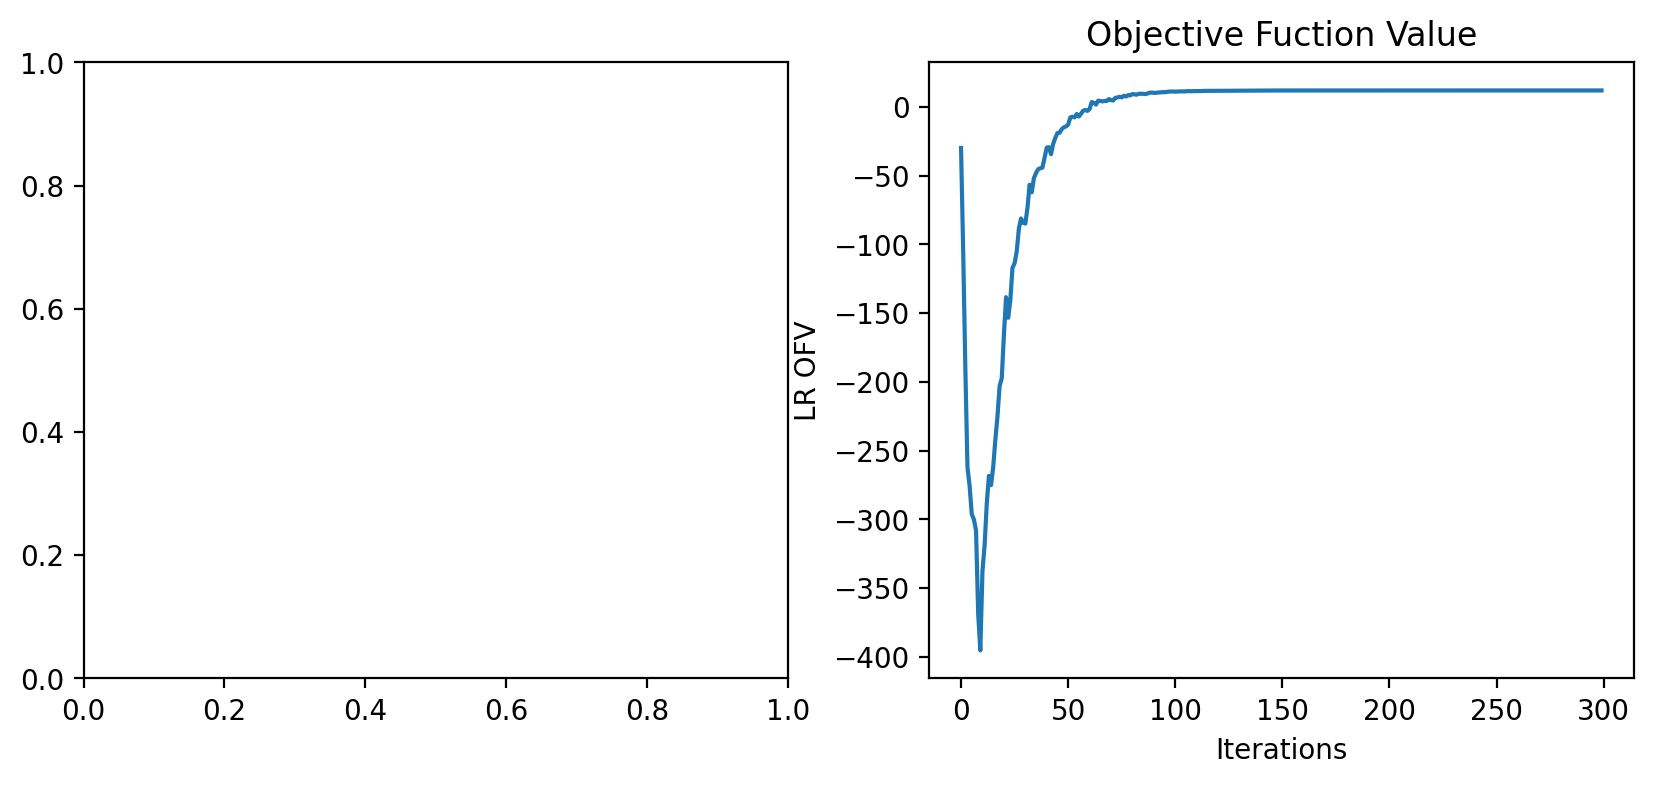

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

# ax[0].plot(multipliers_to_plot[:iteration])
# ax[0].set(xlabel='Iterations', ylabel='Lagragian Multipliers', title='Lagragian Multipliers')
# ax[0].legend(['v1-v2 at t=1 (d=2)', 'v2-v1 at t=1 (d=9)', 'v1-v2 at t=2 (d=3)', 'v2-v1 at t=2 (d=4)'])


ax[1].plot(ofv)
ax[1].set(xlabel='Iterations', ylabel='LR OFV', title='Objective Fuction Value')
plt.show()



# Assignment Problem Archive

In [ ]:
LAX_DTLA = schedule[schedule['od'] == 'LAX_DTLA'].reset_index(drop=True).reset_index()
LAX_DTLA['index'] = LAX_DTLA['index'].apply(lambda x: 'LAX_DTLA_' + str(x))

DTLA_LAX = schedule[schedule['od'] == 'DTLA_LAX'].reset_index(drop=True).reset_index()
DTLA_LAX['index'] = DTLA_LAX['index'].apply(lambda x: 'DTLA_LAX_' + str(x))

In [ ]:
LAX_DTLA['arrival_time'] = LAX_DTLA['schedule'] + 10
DTLA_LAX['arrival_time'] = DTLA_LAX['schedule'] + 10

In [ ]:
nodes = ['Source', 'Sink']
nodes.extend(LAX_DTLA['index']+'A')
nodes.extend(LAX_DTLA['index']+'B')
nodes.extend(DTLA_LAX['index']+'A')
nodes.extend(DTLA_LAX['index']+'B')

In [ ]:
edges = [('Source', 'Sink')]
cost = [-100]
for i in LAX_DTLA['index']:
    edges.append(('Source', i+'A'))
    cost.append(1)
    edges.append((i+'A', i+'B'))
    cost.append(0)
    edges.append((i+'B', 'Sink'))
    cost.append(0)
for i in DTLA_LAX['index']:
    edges.append(('Source', i+'A'))
    cost.append(1)
    edges.append((i+'A', i+'B'))
    cost.append(0)
    edges.append((i+'B', 'Sink'))
    cost.append(0)

for previous_task in LAX_DTLA.iterrows():
    for next_task in LAX_DTLA.iterrows():
        if previous_task[1]['arrival_time']+10 <= next_task[1]['schedule']:
            edges.append((previous_task[1]['index']+'B', next_task[1]['index']+'A'))
            cost.append(-1)

for previous_task in DTLA_LAX.iterrows():
    for next_task in DTLA_LAX.iterrows():
        if previous_task[1]['arrival_time']+10 <= next_task[1]['schedule']:
            edges.append((previous_task[1]['index']+'B', next_task[1]['index']+'A'))
            cost.append(0)

for previous_task in LAX_DTLA.iterrows():
    for next_task in DTLA_LAX.iterrows():
        if previous_task[1]['arrival_time'] <= next_task[1]['schedule']:
            edges.append((previous_task[1]['index']+'B', next_task[1]['index']+'A'))
            cost.append(0)

for previous_task in DTLA_LAX.iterrows():
    for next_task in LAX_DTLA.iterrows():
        if previous_task[1]['arrival_time'] <= next_task[1]['schedule']:
            edges.append((previous_task[1]['index']+'B', next_task[1]['index']+'A'))
            cost.append(0)

In [ ]:
capacities = [GRB.INFINITY] + [1] * len(edges)
capacities = dict(zip(edges, capacities))

cost = dict(zip(edges, cost))
supply = {'Source': -20, 'Sink': 20}

In [ ]:
m = Model("MCNF")

flow = m.addVars(edges, obj=cost, name="flow", lb=0, ub=capacities)
for n in nodes:
    m.addConstr(sum(flow[i, j] for i, j in edges if j == n) -
                sum(flow[i, j] for i, j in edges if i == n) == supply.get(n, 0), f"node_{n}")

for i, j in edges:
    if i.endswith('A') and j.endswith('B'):
        m.addConstr(flow[i, j] == 1, f"flow_{i}_to_{j}")

m.optimize()

if m.status == GRB.OPTIMAL:
    solution = m.getAttr('x', flow)
    flow_sum = sum(solution[i, j] for (i, j) in edges if i == 'Source' and j.endswith('A'))
    print("Sum of flow from Source to nodes with A:", flow_sum)
else:
    print("No optimal solution found.")
